### Natural Learning Processing with Disaster Tweets

Predict which Tweets are disaster tweets and which are not

Competetion Page: https://www.kaggle.com/competitions/nlp-getting-started/overview  
Data: https://www.kaggle.com/competitions/nlp-getting-started/data

The dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.:https://www.figure-eight.com/data-for-everyone/




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score,plot_confusion_matrix,classification_report,f1_score

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import nltk
from collections import defaultdict
from nltk.corpus import stopwords
import string
from collections import Counter


In [2]:
#loading files
train_df=pd.read_csv(r"C:\Users\Abhishek Mehra\Desktop\Workspace\Data Files\Disaster Tweet\train.csv")
test_df=pd.read_csv(r"C:\Users\Abhishek Mehra\Desktop\Workspace\Data Files\Disaster Tweet\test.csv")


## **EDA**

In [3]:
train_df.head()      #First look at the train dataset

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.isnull().sum()    #Looking at the number of missing values

id             0
keyword       26
location    1105
text           0
dtype: int64

In [5]:
train_df.isnull().sum()   #missing values in train

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


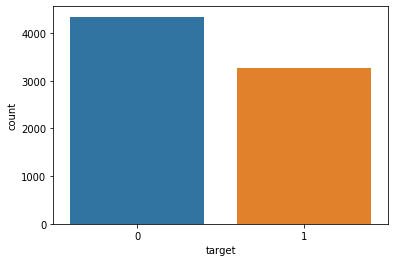

In [7]:
sns.countplot(x=train_df.target)

1. Distribution between disaster and non disaster tweets is similar.  
2. There are more number of non disaster tweets than that of disaster.


*Location*

Text(0.5, 1.0, 'Least common names in country column')

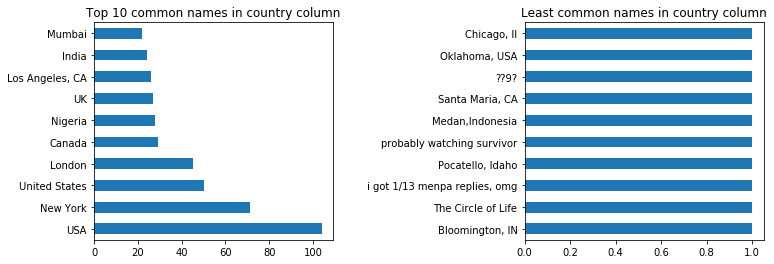

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
top=train_df['location'].value_counts()[:10]    #top 10 common names in country column
top.plot.barh(ax=ax1)
ax1.set_title('Top 10 common names in country column')

plt.subplots_adjust(wspace=0.8)   #to adjust spacing between the graphs


last=train_df['location'].value_counts(ascending=True)[:10]  # Least common names in location column
last.plot.barh(ax=ax2)
ax2.set_title('Least common names in country column')

Location of maximum tweets is USA.Location also has data which is neither city name or country name.Data cleaning is required. The names can be cleaned to get city or the country names in the respective rows.

*Keyword*

In [9]:
train_df['keyword'].nunique()   #221 unique values in keywords

221

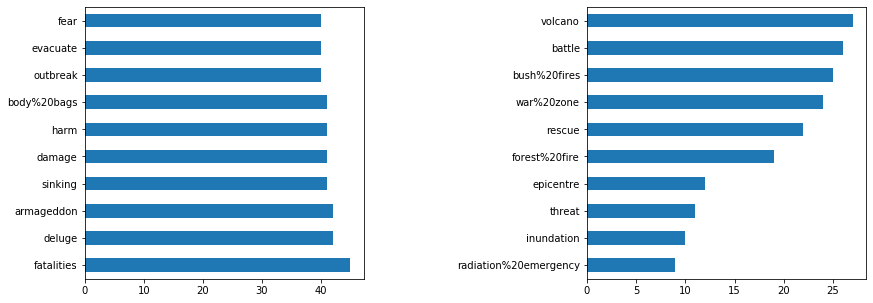

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
most=train_df['keyword'].value_counts()[:10]  #most common keywords
most.plot.barh(ax=ax1)

plt.subplots_adjust(wspace=0.8)

least=train_df['keyword'].value_counts(ascending=True)[:10]
least.plot.barh(ax=ax2)

Keywords have numerical and irrelavant/unnecessary characters like %.Removing these would  help  the model to make better decisions

*Comparing dataset on number of characters*

Text(0.5, 1.0, 'non-disaster tweets')

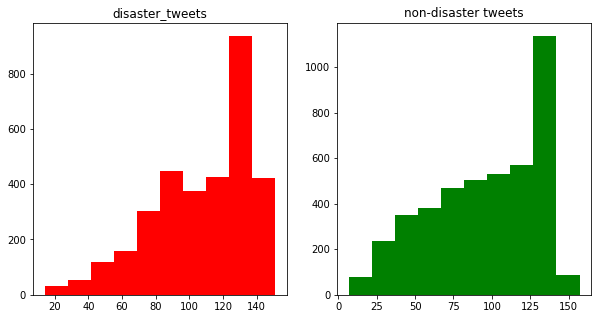

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))    #plt.subplot creates a figure and axes
tweet_len = train_df[train_df['target']==1].text.str.len()  #.str will convert object into string
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster_tweets')
         
tweet_len = train_df[train_df['target']==0].text.str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('non-disaster tweets')

1. The distribution between characters of disaster and non disaster tweets is similar.
1. Most of the tweets are between 120 to 140 characters.

*Number of words in tweets*

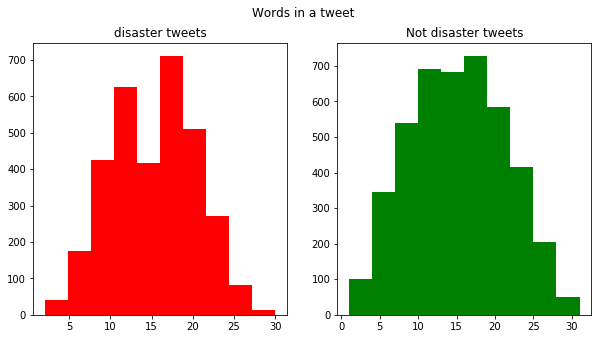

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

*Create a corpus*

In [13]:
def create_corpus(target):   # target-1 for disaster or ,0 for non disaster word corpus
    corpus=[]
    
    for x in train_df[train_df['target']==target].text.str.split():
        for i in x:
            corpus.append(i)
            
    return corpus        #return a list of all the words

*Common stopwords in tweets*

In [14]:
stop=stopwords.words('english')   # we will use stop words from nltk package

In [15]:
corpus=create_corpus(0)  #corpus with non disastr tweets created

dic=defaultdict(int)  #to store the word and its frequency
for word in corpus:   #iteraiting over corpus
    if word in stop:
        dic[word]+=1   #if a stop word then count of plus 1, default dict will give a key of its own if not provided
        
        
top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:10]  #sort in descending order based on frequency of words


<BarContainer object of 10 artists>

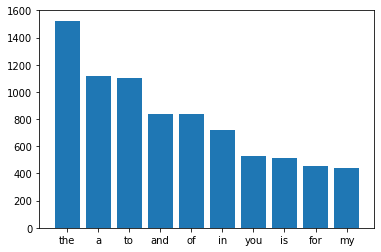

In [16]:
x,y=zip(*top)   #zip returns tuples
plt.bar(x,y)

In [17]:
corpus=create_corpus(1)

dic=defaultdict(int)   #defaultdict is different from dictionary - provides default key when key dosen't exist
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:10]        

<BarContainer object of 10 artists>

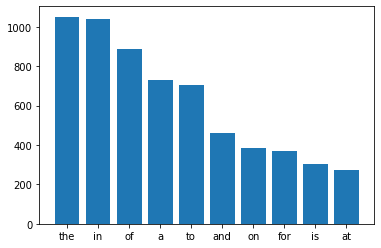

In [18]:
x,y =zip(*top)
plt.bar(x,y)

*Analyzing punctuations*

In [19]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)

dic=defaultdict(int)

punc = string.punctuation    #string.punctuation returns all set of punctuations

for i in corpus:
    if i in punc:
        dic[i]+=1
        

        

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'disaster tweets')

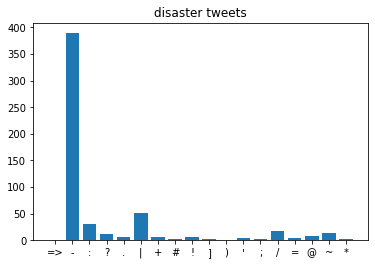

In [20]:
x,y=zip(*dic.items())       #zip return a tuple of the items in dic
plt.bar(x,y)
plt.title('disaster tweets')

In [21]:
corpus=create_corpus(0)
punc= string.punctuation
dic=defaultdict(int)
for i in corpus:
    if i in punc:
        dic[i]+=1
        

Text(0.5, 1.0, 'puntuations in non-disaster tweets')

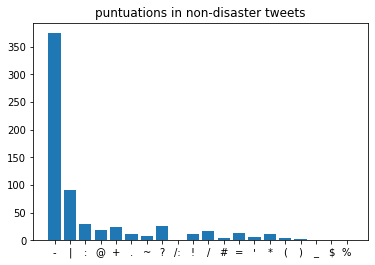

In [22]:
x,y=zip(*dic.items())
plt.bar(x,y)
plt.title('puntuations in non-disaster tweets')

*Common Words*


In [23]:
counter=Counter(corpus)    #giving corpus to Counter object

most=counter.most_common() #most_common returns a list of most common elements,with the frequency
x=[]                       #to store word
y=[]                       #to store its count

for word,count in most[:40]:
    if(word not in stop):
        x.append(word)
        y.append(count)


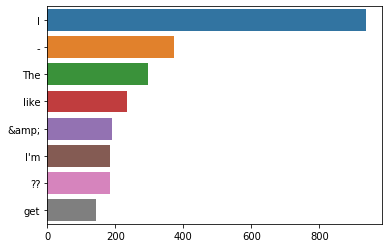

In [24]:
sns.barplot(x=y,y=x)

#### Data cleaning

Removing punctuations,removing html tags and emojis since they provide little or no insights.

*Replacing the missing values with modes of repective column*

In [25]:
train_df['keyword'].fillna(train_df['keyword'].mode()[0],inplace=True)   #replacing NaN in keyword with mode values
test_df['keyword'].fillna(test_df['keyword'].mode()[0],inplace=True)

train_df['location'].fillna(train_df['location'].mode()[0],inplace=True)  #replacing NaN in location with mode values
test_df['location'].fillna(test_df['location'].mode()[0],inplace = True)

*Concating test and train*


In [26]:
df=pd.concat([train_df.assign(ind='train'),test_df.assign(ind='test')]) #concating after assigning a new column whcih will help to separte test and train later

In [27]:
df.shape

(10876, 6)

*Removing HTML tags*

In [28]:
def remove_html(text):
    html=re.compile(r'<.*?>')    
    return html.sub(r'',text)   #removing html texts


In [29]:
df['text']=df['text'].apply(lambda x:remove_html(x))   #apply lambda to all values in df series

*Removing URL*

In [30]:
def remove_url(text):
    url=re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [31]:
df['text']=df['text'].apply(lambda x:remove_url(x))  #pass a function and apply it to every single value of the series

*Removing Emojis*

In [32]:
def remove_emoji(text):
    emoji_pattern = re.compile('['
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                ']+',flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)

In [33]:
df['text']=df['text'].apply(lambda x:remove_emoji(x))

*Removing Punctuations*

In [34]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [35]:
df['text']=df['text'].apply(lambda x: remove_punct(x))

### Model Building

*Separting test and train datasets*

In [36]:
train=df[df['ind'].eq('train')]                  #separating train data by the indicator we put ealier
test=df[df['ind'].eq('test')]
train=train.drop(axis=1,labels='ind')            #dropping the indicator from training set
test=test.drop(['ind'],axis=1)                   #dropping the indicator from test set

*Function to make train and validation sets*

In [37]:
def splits(x,y):
    return(train_test_split(x,y,test_size=0.2,random_state=1))

*Function to calculate scores*  
F1-score is the harmonic mean between precision and recall.


In [38]:
def scores(mdl):
    p=mdl.predict(X_test)          #predicting test set
    print(f1_score(y_test,p))      #calculating f1 score


*Converting into vectors*

In [39]:
cv = CountVectorizer()  #creating cv ,CountVectorizer object

In [40]:
cv_train=cv.fit_transform(train['text'])     
cv_test=cv.transform(test['text'])

*Putting vectors to a data frame*

In [41]:
training=pd.DataFrame(cv_train.todense(),columns=cv.get_feature_names_out())  #converting sparse matrix to
testing=pd.DataFrame(cv_test.todense(),columns=cv.get_feature_names_out())

One Hot encoding keyword and location column.  
These features  provide more insights to our model

In [42]:
gd=pd.get_dummies(train_df['keyword'])
gdt=pd.get_dummies(test_df['keyword'])
gd,gdt=gd.align(gdt,join='left',axis=1)   # the join=left method creates columns(whichever is missing in either of them).Both df has same columns in the end

gd2=pd.get_dummies(train_df['location'])
gdt2=pd.get_dummies(test_df['location'])
gd2,gdt2=gd2.align(gdt2,join='left',axis=1)  

*Combining encoded columns with vectors.All features will provide insight to the model*

In [43]:
training=pd.concat([training,gd,gd2],axis=1)  #joining vectorised text,location and keyword features
testing=pd.concat([testing,gdt,gdt2],axis=1)

In [44]:
training.fillna(0,inplace=True)   #filling zeros in the position created by aligning
testing.fillna(0,inplace=True) 

In [45]:
X_train,X_test,y_train,y_test=splits(training,train['target'])  #creating validation and train set

In [46]:
rf=RandomForestClassifier(n_estimators=350,n_jobs=-1)

In [47]:
rf.fit(X_train,y_train) 
rf.predict(X_test)
scores(rf)

0.7201458523245214


In [48]:
pred=rf.predict(testing)

#### Submitting results

In [49]:
sub=pd.DataFrame({'id':test['id'],'target':pred})
sub.to_csv('submission.csv',index=False)